# 0. Import the necessary libraries

In [1]:
import os
import sys

# Set the working directory to the root directory of the project
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Create the dataset and dataloaders

In [3]:
from main import load_urytox, create_dataloaders

The device being used is cuda



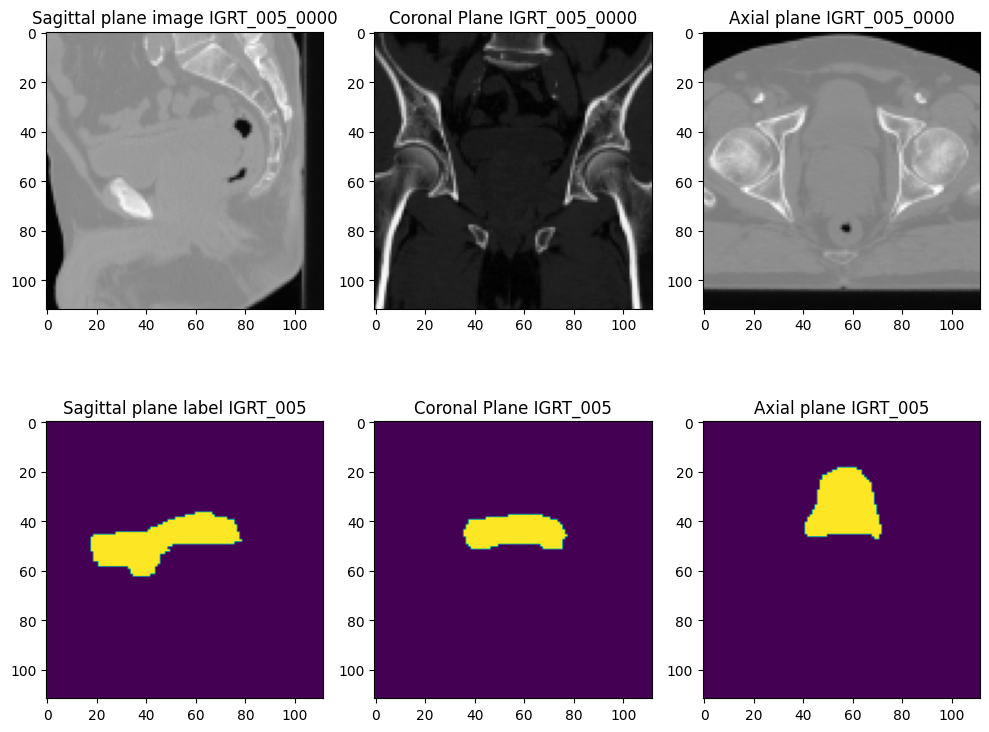

There are 172 pairs of images and labels
The images have shape torch.Size([1, 112, 112, 112])
The labels have shape torch.Size([2, 112, 112, 112])



In [4]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device being used is {device}\n')

# Set the seeds
seed = torch.Generator().manual_seed(42)

# Load the dataset
dataset = load_urytox(os.path.split(os.getcwd())[0])

# Create the dataloaders
trainloader, validloader, testloader = create_dataloaders(
    dataset, seed, batch_size=1, train_size=0.7)

In [6]:
image, target, name = next(iter(testloader))

image, target = image.to(device), target.to(device)

# U-Net

In [7]:
from src.model.unet import UNet

In [8]:
model = UNet(in_channels=1, n_classes=2, filter_factor=2, logits=True, is3d=True)

In [9]:
checkpoint_path = os.path.split(os.getcwd())[0] + '/results/trained_models/test_bladder_unet.pth'

In [10]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

model = model.eval()
model = model.to(device)

In [11]:
mask = model.forward(image)

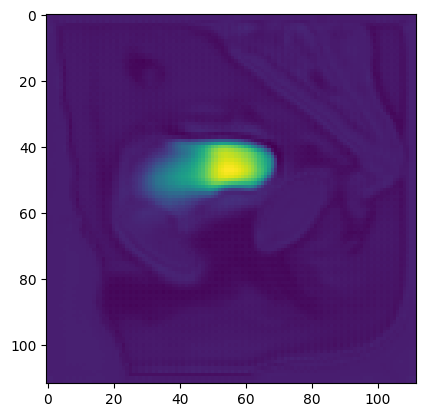

In [12]:
plt.imshow(mask.cpu().detach().numpy()[0, 1, :, :, 56])

# Probabilistic U-Net

In [13]:
from src.model.probunet import ProbabilisticUNet

In [14]:
model = ProbabilisticUNet(in_channels=1,
                          n_classes=2,
                          latent_dim=6,
                          linear_dim=14 ** 3,
                          unet_factor=2,
                          vae_factor=2,
                          logits=True,
                          is3d=True)

In [15]:
checkpoint_path = os.path.split(os.getcwd())[0] + '/results/trained_models/test_bladder_sum_logits.pth'

In [16]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

model = model.eval()
model = model.to(device)

## Generate 'N' segmentations for the first test batch

In [17]:
# Forward pass to generate the segmentation and initialize the prior
feats, prior = model.forward(image, target, train=False)

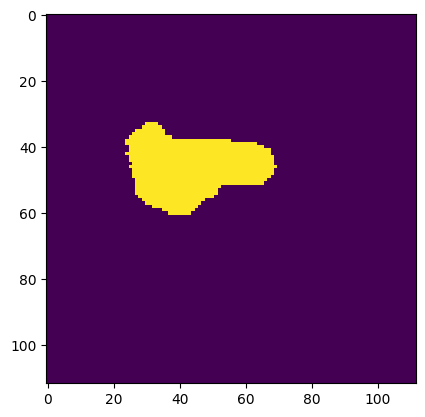

In [18]:
plt.imshow(target.cpu().detach().numpy()[0, 1, :, :, 56])

In [19]:
unet_feats = model.sample()

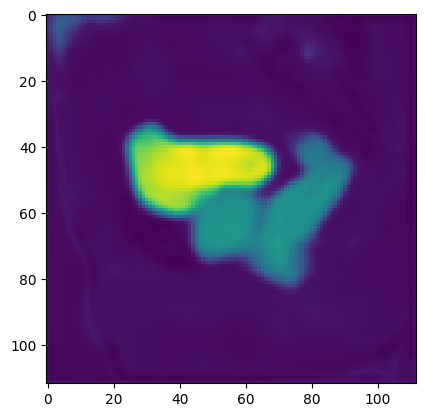

In [20]:
plt.imshow(unet_feats.cpu().detach().numpy()[0][1, :, :, 56])

In [21]:
def binarize_segmentations(segmentation_tensors):
    return torch.where(segmentation_tensors > 0.4, torch.tensor(1), torch.tensor(0))

In [33]:
def binarize_segmentations(segmentation_tensors, threshold=2):
    # Binarize the segmentation tensors based on the threshold
    binarized_segmentation = torch.where(segmentation_tensors > threshold, segmentation_tensors, torch.tensor(0.0))

    # Apply softmax to the binarized segmentation
    softmaxed_binarized_segmentation = torch.softmax(binarized_segmentation, dim=1)

    return softmaxed_binarized_segmentation


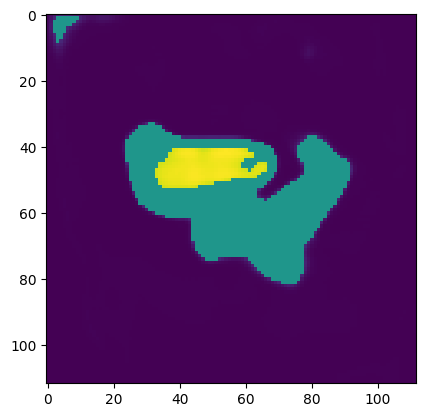

In [34]:
plt.imshow(binarize_segmentations(unet_feats).cpu().detach().numpy()[0][1, :, :, 56])

In [35]:
segmentations = []

for i in range(50):
    sample = model.sample(train=False)
    segmentations.append(binarize_segmentations(sample).cpu().detach())
    # plt.imshow(binarize_segmentations(sample).cpu().detach().numpy()[0, 1, :, :, 56])
    # plt.show()

In [36]:
# Concatenate the list of masks into a single torch tensor with shape [50, 2, 112, 112, 112]
batch_masks = torch.cat(segmentations, dim=0)

# Convert the torch tensor to a numpy array for np.std
batch_masks_np = batch_masks.numpy()

# Compute the standard deviation along the batch dimension (axis=0)
uncertainty_map = torch.tensor(np.std(batch_masks_np, axis=0))

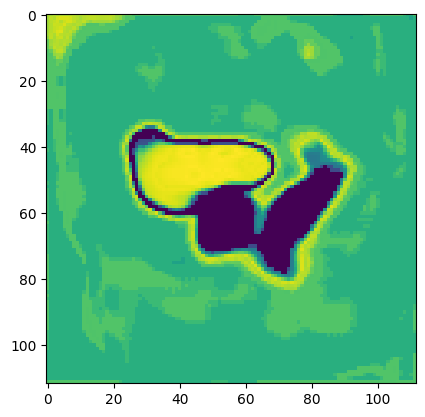

In [37]:
plt.imshow(uncertainty_map[1][:, :, 56])